#### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

tf.config.list_physical_devices('gpu')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

%matplotlib inline


2024-04-04 14:40:59.142281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 14:40:59.164709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 14:40:59.164733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 14:40:59.165304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 14:40:59.169260: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-04 14:41:01.046631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:41:01.076712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:41:01.076962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Set Path Variable

In [2]:
main_directory = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest'

class_labels = ['normal', 'slowing-wave', 'spike-and-wave']
class_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder

dest_list = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder
waveletsTypes = ['mexh','morl', 'gaus1', 'gaus2']
splits = ['train', 'valid', 'test']

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)



#### Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def plotImages(images_arr,train_labels):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(train_labels[i])
        i = i+1
    plt.tight_layout()
    plt.show()

# Model Implementation

### Prepare Callbacks

In [5]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

os.chdir(main_directory)

## Google LeNEt

In [6]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    tf.keras.backend.clear_session()
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model



## Vgg16

In [7]:
def plot_accuracy_loss(loss,val_loss,accuracy,val_accuracy):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
def test_model(model,test_batches,model_type):

    y_test=test_batches.classes

    model.evaluate(test_batches)

    predictions = model.predict(test_batches, verbose = 2)

    if model_type == "googlenet":
        y_pred = np.argmax(predictions[1], axis = 1)
    else:
        y_pred = np.argmax(predictions, axis = 1)    

    cm = confusion_matrix(y_test, y_pred)

    cm_plot_labels = [0, 1, 2]
    plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

    print(accuracy_score(y_test, y_pred))

    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

In [10]:
def evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath):

    mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

    ###### Train Model
    history = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

    google_lenet.save(checkpoint_filepath+'/googlenet/GoogLenet_-final.h5')
    google_lenet.save_weights(checkpoint_filepath+'/googlenet/GoogLenet_-final.tf', save_format='tf')

    ###### Model Plots
    plot_accuracy_loss(history.history['dense_4_loss'],history.history['val_dense_4_loss'],history.history['dense_4_accuracy'],history.history['val_dense_4_accuracy'])

    return google_lenet


In [11]:
def evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath):
    ###### Train Model
    history = vgg16_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    vgg16_model_custom.save(checkpoint_filepath+'/vgg16/VGG16_baseline.h5')
    vgg16_model_custom.save_weights(checkpoint_filepath+'/vgg16/VGG16_baseline.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return vgg16_model_custom

------------------- mexh -------------------------
Found 702537 images belonging to 3 classes.
Found 93566 images belonging to 3 classes.
Found 119907 images belonging to 3 classes.


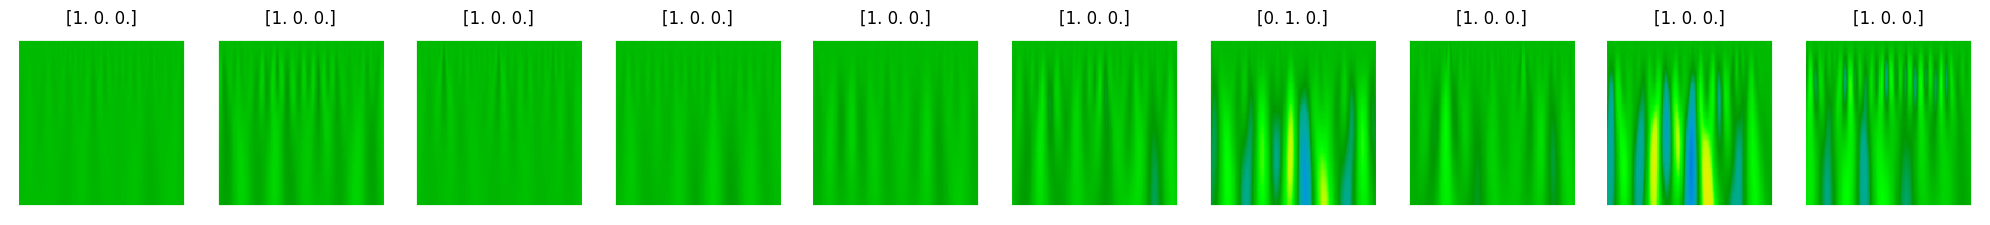

2024-04-04 14:41:27.706568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:41:27.706698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 14:41:27.706750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-04-04 14:41:34.312521: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-04 14:41:36.335651: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e3f2ce5d4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 14:41:36.335669: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-04 14:41:36.345076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712223696.413006  503775 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21955/21955 [==============================] - 721s 32ms/step - loss: 1.4458 - dense_4_loss: 0.4743 - dense_1_loss: 0.4936 - dense_3_loss: 0.4779 - dense_4_accuracy: 0.8007 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.7991 - val_loss: 1.6077 - val_dense_4_loss: 0.5293 - val_dense_1_loss: 0.5465 - val_dense_3_loss: 0.5319 - val_dense_4_accuracy: 0.7767 - val_dense_1_accuracy: 0.7692 - val_dense_3_accuracy: 0.7720
Epoch 2/30
21955/21955 [==============================] - 692s 32ms/step - loss: 1.2271 - dense_4_loss: 0.4020 - dense_1_loss: 0.4190 - dense_3_loss: 0.4062 - dense_4_accuracy: 0.8334 - dense_1_accuracy: 0.8271 - dense_3_accuracy: 0.8322 - val_loss: 1.5340 - val_dense_4_loss: 0.5191 - val_dense_1_loss: 0.5046 - val_dense_3_loss: 0.5103 - val_dense_4_accuracy: 0.7836 - val_dense_1_accuracy: 0.7783 - val_dense_3_accuracy: 0.7821
Epoch 3/30
21955/21955 [==============================] - 690s 31ms/step - loss: 1.1467 - dense_4_loss: 0.3745 - dense_1_loss: 0.3928 - dense_3_loss:

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


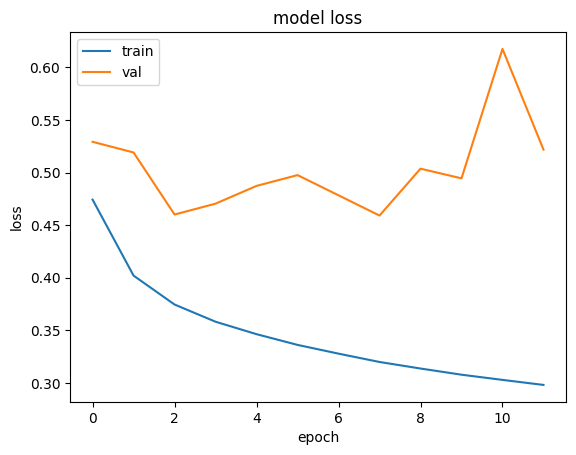

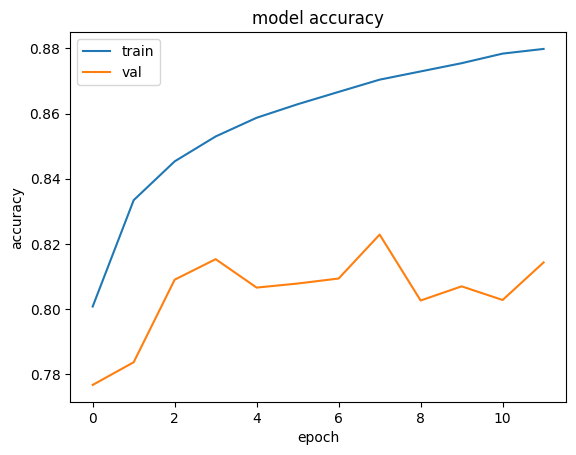

7495/7495 [==============================] - 102s 14ms/step - loss: 1.4778 - dense_4_loss: 0.5002 - dense_1_loss: 0.4868 - dense_3_loss: 0.4908 - dense_4_accuracy: 0.8129 - dense_1_accuracy: 0.8076 - dense_3_accuracy: 0.8173
7495/7495 - 74s - 74s/epoch - 10ms/step
Confusion matrix, without normalization
[[82610  3243  1688]
 [11141 10687  3289]
 [ 1585  2121  3543]]


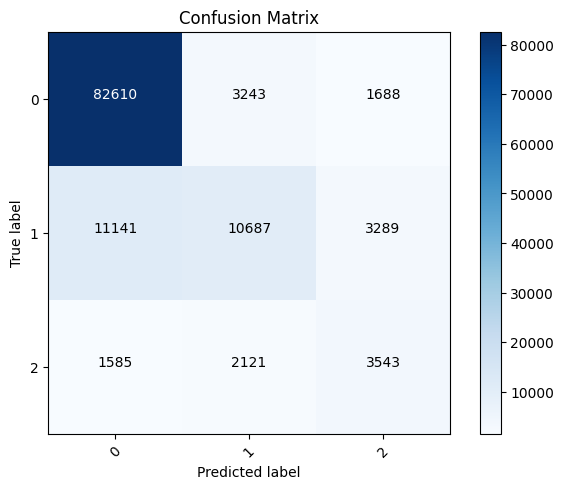

0.8076259100803123
              precision    recall  f1-score   support

     class 0    0.86651   0.94367   0.90345     87541
     class 1    0.66582   0.42549   0.51919     25117
     class 2    0.41585   0.48876   0.44936      7249

    accuracy                        0.80763    119907
   macro avg    0.64939   0.61931   0.62400    119907
weighted avg    0.79723   0.80763   0.79551    119907

Epoch 1/30
21955/21955 [==============================] - 2521s 114ms/step - loss: 0.4184 - accuracy: 0.8270 - val_loss: 0.5129 - val_accuracy: 0.7916
Epoch 2/30
21955/21955 [==============================] - 2494s 114ms/step - loss: 0.3565 - accuracy: 0.8546 - val_loss: 0.4891 - val_accuracy: 0.8115
Epoch 3/30
21955/21955 [==============================] - 2490s 113ms/step - loss: 0.3343 - accuracy: 0.8639 - val_loss: 0.4853 - val_accuracy: 0.8144
Epoch 4/30
21955/21955 [==============================] - 2492s 113ms/step - loss: 0.3203 - accuracy: 0.8708 - val_loss: 0.5068 - val_accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


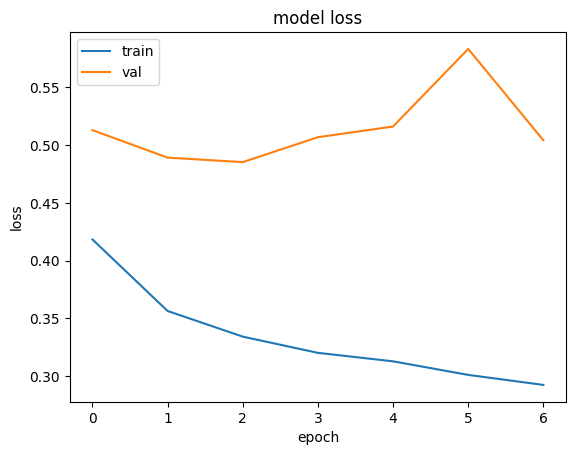

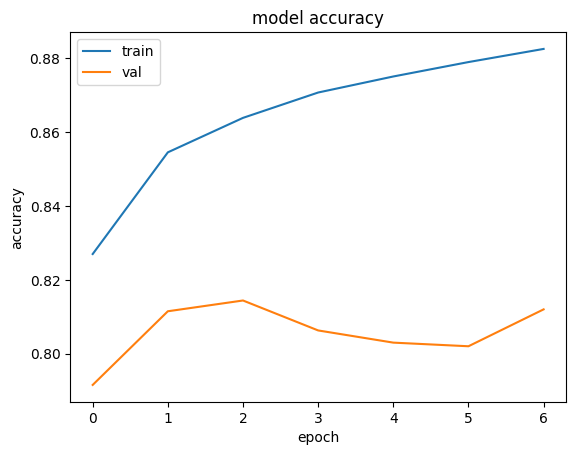

7495/7495 [==============================] - 168s 22ms/step - loss: 0.4795 - accuracy: 0.8068
7495/7495 - 157s - 157s/epoch - 21ms/step
Confusion matrix, without normalization
[[81537  3979  2025]
 [10182 11250  3685]
 [ 1415  1878  3956]]


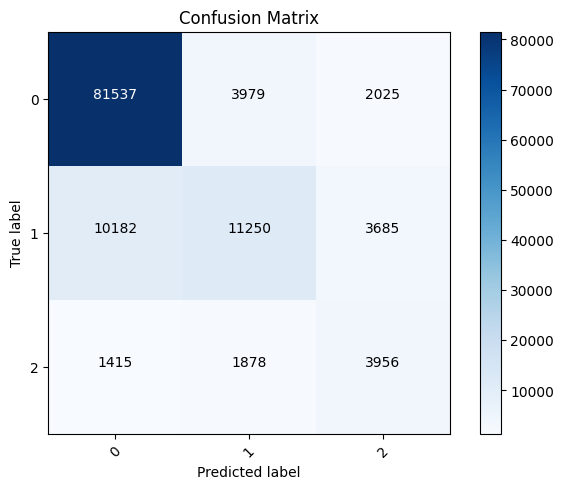

0.8068169498027639
              precision    recall  f1-score   support

     class 0    0.87548   0.93141   0.90258     87541
     class 1    0.65763   0.44790   0.53287     25117
     class 2    0.40927   0.54573   0.46775      7249

    accuracy                        0.80682    119907
   macro avg    0.64746   0.64168   0.63440    119907
weighted avg    0.80166   0.80682   0.79885    119907

------------------- morl -------------------------
Found 534652 images belonging to 3 classes.
Found 80392 images belonging to 3 classes.
Found 119943 images belonging to 3 classes.


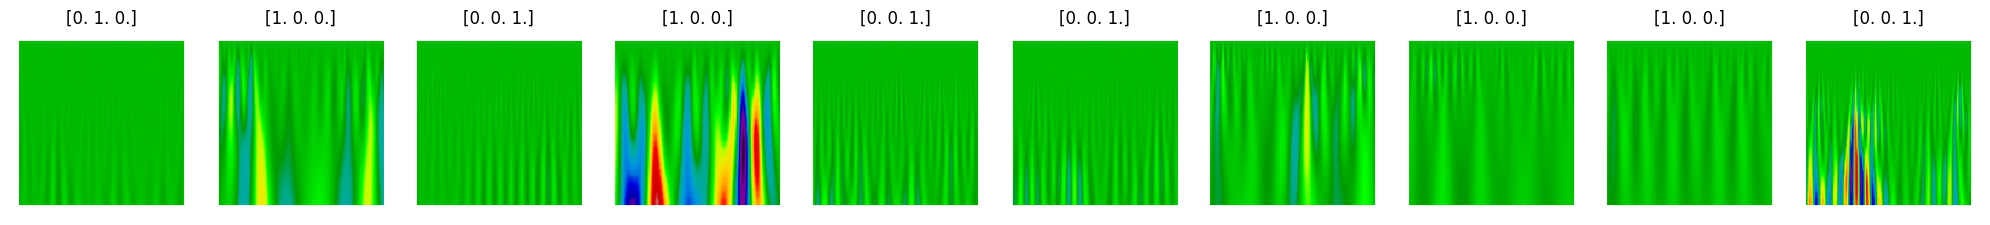

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


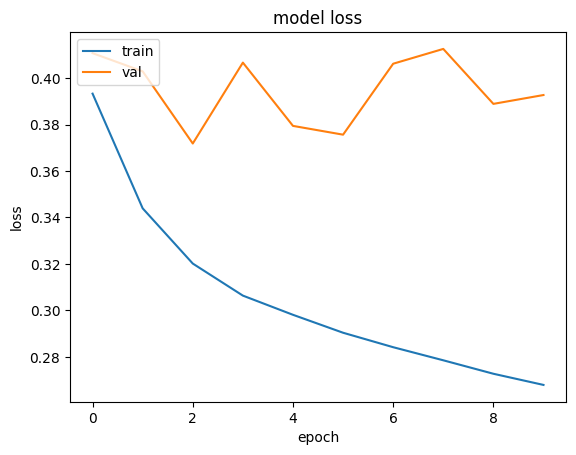

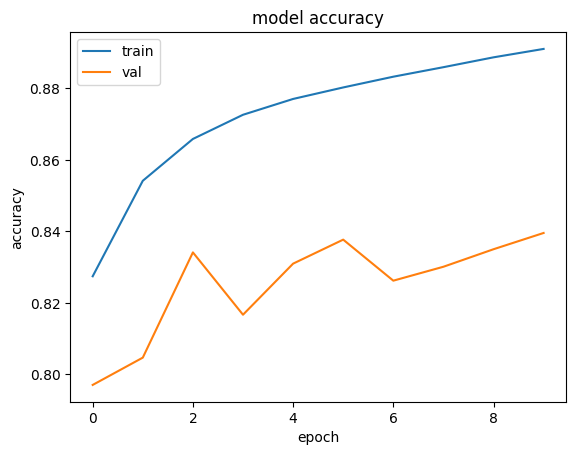

7497/7497 [==============================] - 112s 15ms/step - loss: 1.0183 - dense_4_loss: 0.3373 - dense_1_loss: 0.3343 - dense_3_loss: 0.3466 - dense_4_accuracy: 0.8521 - dense_1_accuracy: 0.8404 - dense_3_accuracy: 0.8419
7497/7497 - 78s - 78s/epoch - 10ms/step
Confusion matrix, without normalization
[[82619  2585  2373]
 [ 1705 13506  9906]
 [  345  2225  4679]]


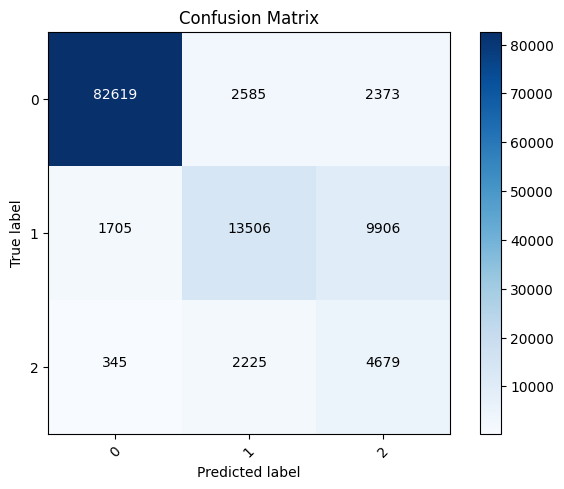

0.8404325387892583
              precision    recall  f1-score   support

     class 0    0.97579   0.94339   0.95931     87577
     class 1    0.73739   0.53772   0.62192     25117
     class 2    0.27592   0.64547   0.38658      7249

    accuracy                        0.84043    119943
   macro avg    0.66303   0.70886   0.65594    119943
weighted avg    0.88357   0.84043   0.85405    119943

Epoch 1/30
16708/16708 [==============================] - 1935s 116ms/step - loss: 0.3767 - accuracy: 0.8370 - val_loss: 0.3887 - val_accuracy: 0.8112
Epoch 2/30
16708/16708 [==============================] - 1908s 114ms/step - loss: 0.3217 - accuracy: 0.8654 - val_loss: 0.4349 - val_accuracy: 0.8037
Epoch 3/30
16708/16708 [==============================] - 1905s 114ms/step - loss: 0.3014 - accuracy: 0.8751 - val_loss: 0.3832 - val_accuracy: 0.8322
Epoch 4/30
16708/16708 [==============================] - 1904s 114ms/step - loss: 0.2891 - accuracy: 0.8816 - val_loss: 0.4287 - val_accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


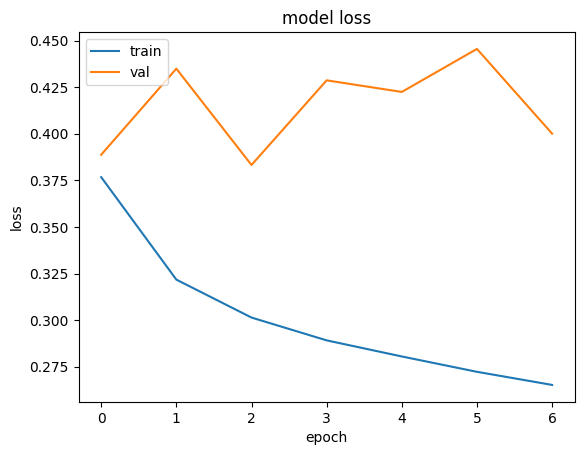

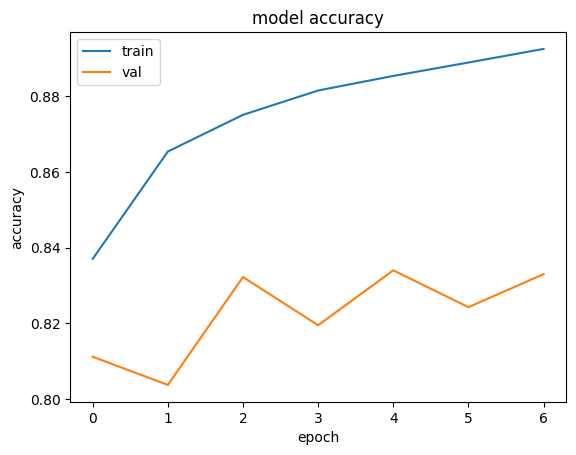

7497/7497 [==============================] - 168s 22ms/step - loss: 0.3408 - accuracy: 0.8547
7497/7497 - 158s - 158s/epoch - 21ms/step
Confusion matrix, without normalization
[[83266  2706  1605]
 [ 1867 15129  8121]
 [  430  2698  4121]]


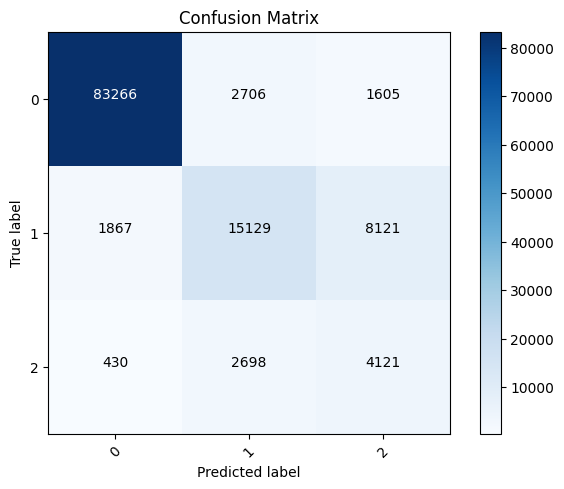

0.854705985343038
              precision    recall  f1-score   support

     class 0    0.97315   0.95077   0.96183     87577
     class 1    0.73681   0.60234   0.66283     25117
     class 2    0.29761   0.56849   0.39069      7249

    accuracy                        0.85471    119943
   macro avg    0.66919   0.70720   0.67178    119943
weighted avg    0.88283   0.85471   0.86470    119943

------------------- gaus1 -------------------------
Found 533942 images belonging to 3 classes.
Found 80437 images belonging to 3 classes.
Found 119915 images belonging to 3 classes.


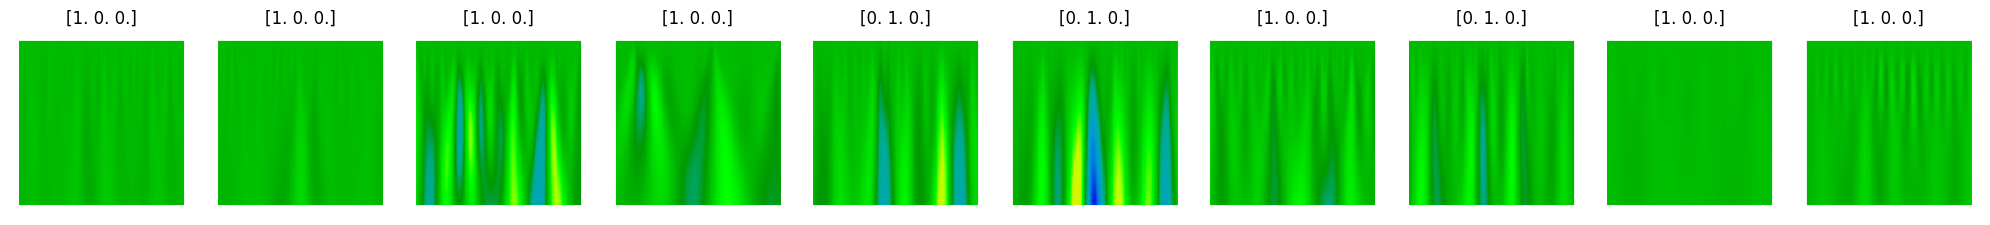

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


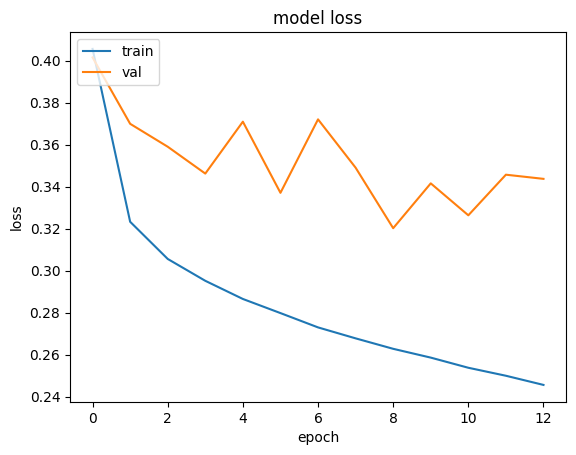

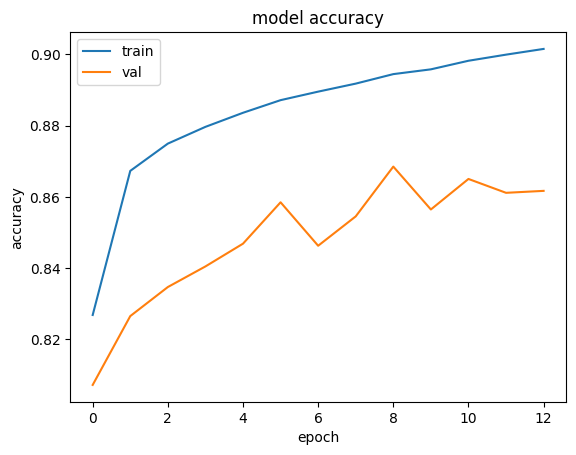

7495/7495 [==============================] - 104s 14ms/step - loss: 0.9075 - dense_4_loss: 0.3054 - dense_1_loss: 0.2964 - dense_3_loss: 0.3057 - dense_4_accuracy: 0.8765 - dense_1_accuracy: 0.8773 - dense_3_accuracy: 0.8734
7495/7495 - 71s - 71s/epoch - 9ms/step
Confusion matrix, without normalization
[[82820  2540  2189]
 [ 1559 17712  5846]
 [  148  2428  4673]]


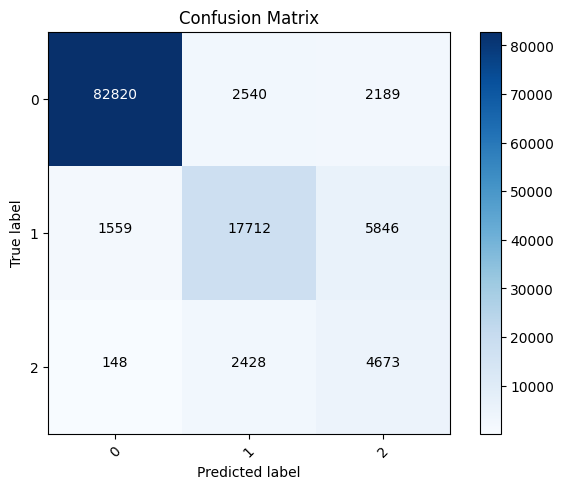

0.877329775257474
              precision    recall  f1-score   support

     class 0    0.97981   0.94598   0.96260     87549
     class 1    0.78095   0.70518   0.74113     25117
     class 2    0.36772   0.64464   0.46831      7249

    accuracy                        0.87733    119915
   macro avg    0.70949   0.76527   0.72401    119915
weighted avg    0.90115   0.87733   0.88633    119915

Epoch 1/30
16686/16686 [==============================] - 1935s 116ms/step - loss: 0.3464 - accuracy: 0.8568 - val_loss: 0.3567 - val_accuracy: 0.8452
Epoch 2/30
16686/16686 [==============================] - 1913s 115ms/step - loss: 0.2951 - accuracy: 0.8795 - val_loss: 0.3595 - val_accuracy: 0.8421
Epoch 3/30
16686/16686 [==============================] - 1909s 114ms/step - loss: 0.2801 - accuracy: 0.8861 - val_loss: 0.3220 - val_accuracy: 0.8654
Epoch 4/30
16686/16686 [==============================] - 1906s 114ms/step - loss: 0.2689 - accuracy: 0.8916 - val_loss: 0.3592 - val_accuracy: 0.85

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


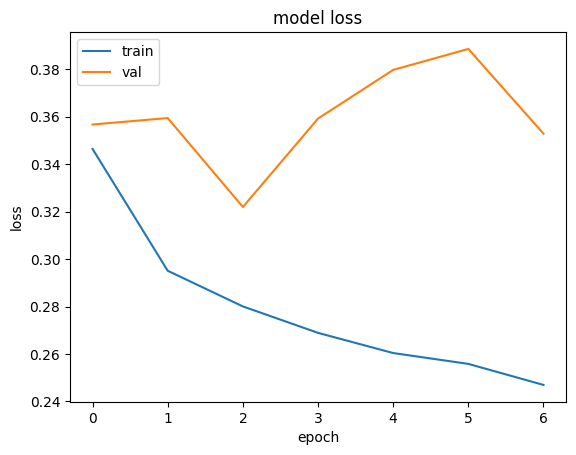

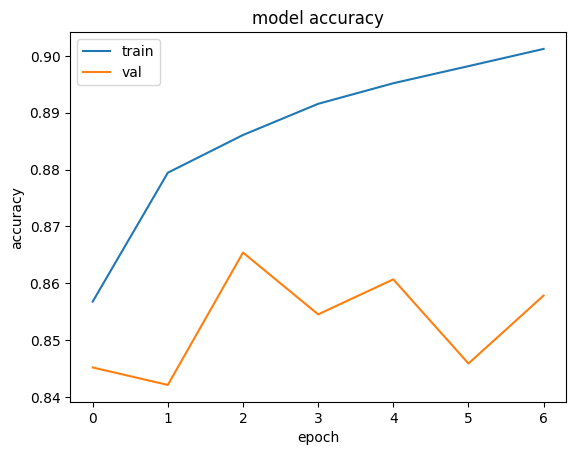

7495/7495 [==============================] - 168s 22ms/step - loss: 0.3076 - accuracy: 0.8718
7495/7495 - 157s - 157s/epoch - 21ms/step
Confusion matrix, without normalization
[[82727  2525  2297]
 [ 1283 17247  6587]
 [  165  2515  4569]]


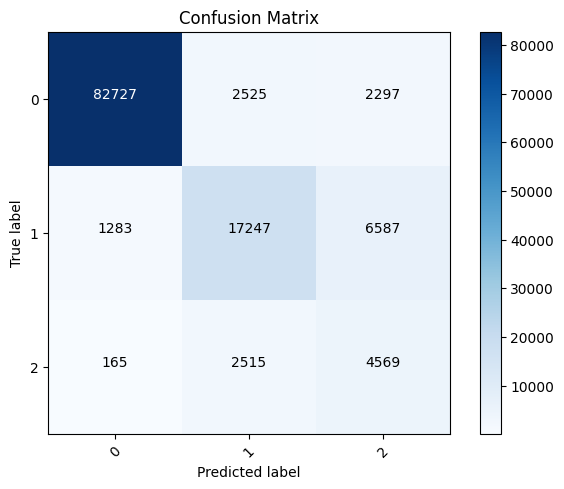

0.8718091981820456
              precision    recall  f1-score   support

     class 0    0.98280   0.94492   0.96349     87549
     class 1    0.77386   0.68667   0.72766     25117
     class 2    0.33963   0.63029   0.44141      7249

    accuracy                        0.87181    119915
   macro avg    0.69876   0.75396   0.71085    119915
weighted avg    0.90015   0.87181   0.88253    119915

------------------- gaus2 -------------------------
Found 533613 images belonging to 3 classes.
Found 80440 images belonging to 3 classes.
Found 119797 images belonging to 3 classes.


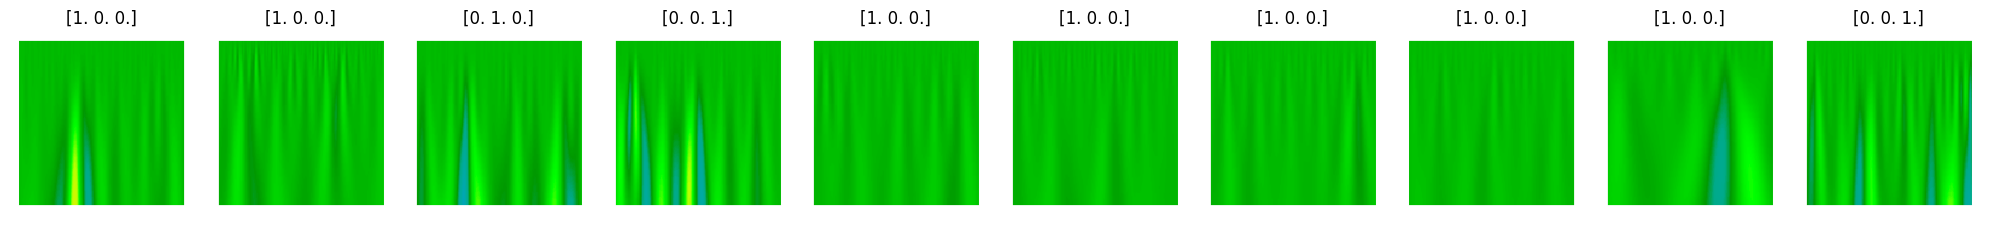

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


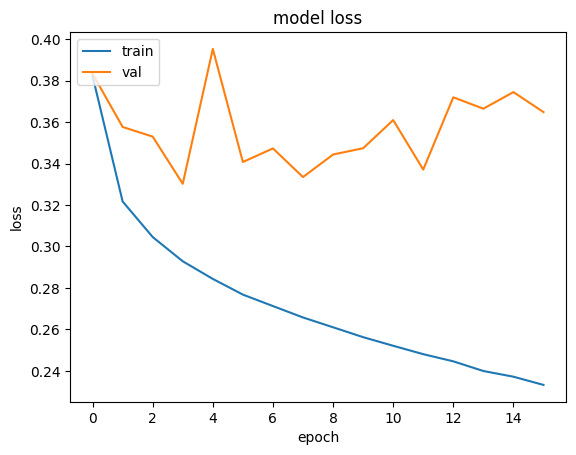

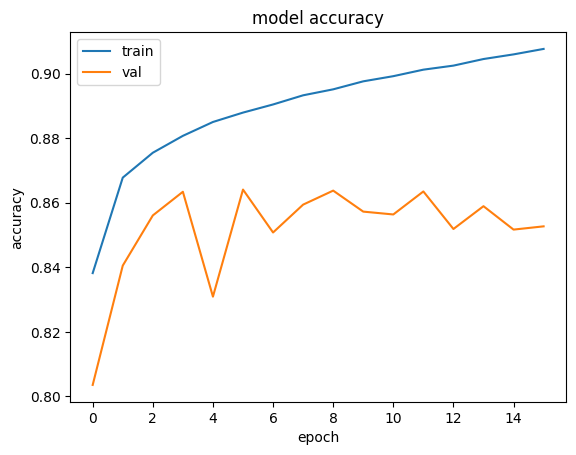

7488/7488 [==============================] - 106s 14ms/step - loss: 0.9254 - dense_4_loss: 0.3120 - dense_1_loss: 0.3035 - dense_3_loss: 0.3100 - dense_4_accuracy: 0.8701 - dense_1_accuracy: 0.8749 - dense_3_accuracy: 0.8701
7488/7488 - 70s - 70s/epoch - 9ms/step
Confusion matrix, without normalization
[[83088  2371  1972]
 [ 1771 17264  6082]
 [  280  2506  4463]]


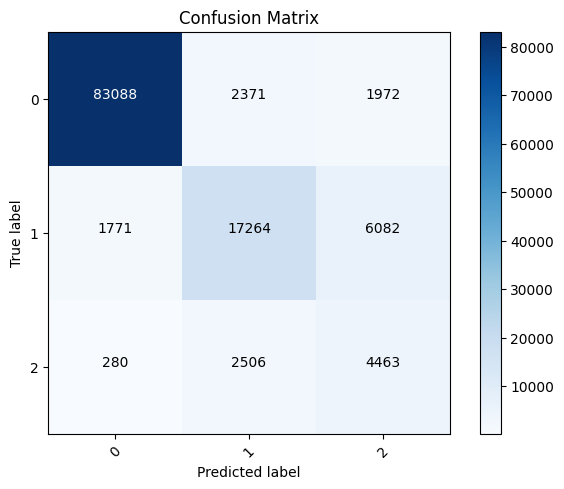

0.8749384375234772
              precision    recall  f1-score   support

     class 0    0.97591   0.95033   0.96295     87431
     class 1    0.77973   0.68734   0.73063     25117
     class 2    0.35656   0.61567   0.45158      7249

    accuracy                        0.87494    119797
   macro avg    0.70406   0.75111   0.71505    119797
weighted avg    0.89730   0.87494   0.88330    119797

Epoch 1/30
16676/16676 [==============================] - 1928s 116ms/step - loss: 0.3466 - accuracy: 0.8566 - val_loss: 0.3504 - val_accuracy: 0.8333
Epoch 2/30
16676/16676 [==============================] - 1911s 115ms/step - loss: 0.2984 - accuracy: 0.8784 - val_loss: 0.3313 - val_accuracy: 0.8616
Epoch 3/30
16676/16676 [==============================] - 1907s 114ms/step - loss: 0.2809 - accuracy: 0.8864 - val_loss: 0.3291 - val_accuracy: 0.8584
Epoch 4/30
16676/16676 [==============================] - 1906s 114ms/step - loss: 0.2693 - accuracy: 0.8918 - val_loss: 0.3444 - val_accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


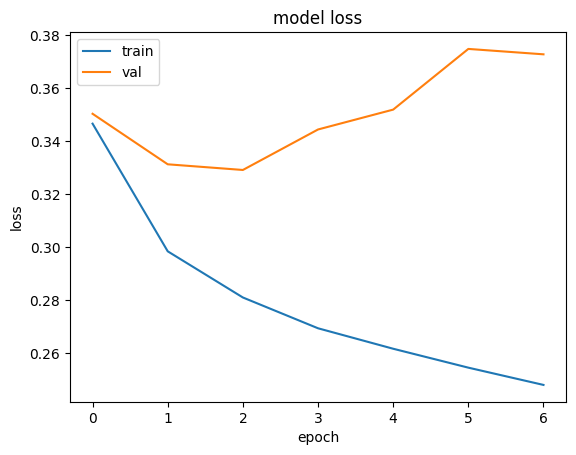

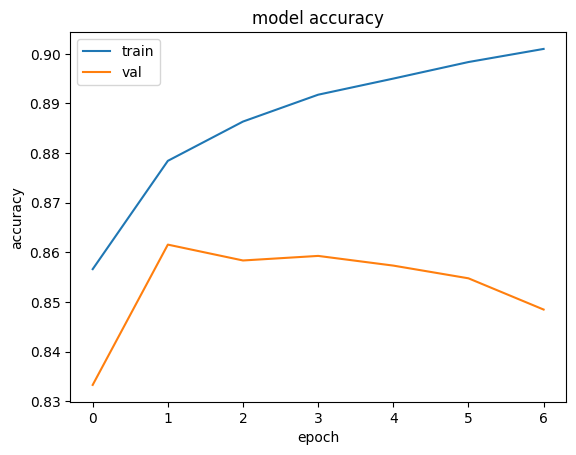

7488/7488 [==============================] - 168s 22ms/step - loss: 0.3181 - accuracy: 0.8515
7488/7488 - 157s - 157s/epoch - 21ms/step
Confusion matrix, without normalization
[[83657  1564  2210]
 [ 3591 13374  8152]
 [  334  1942  4973]]


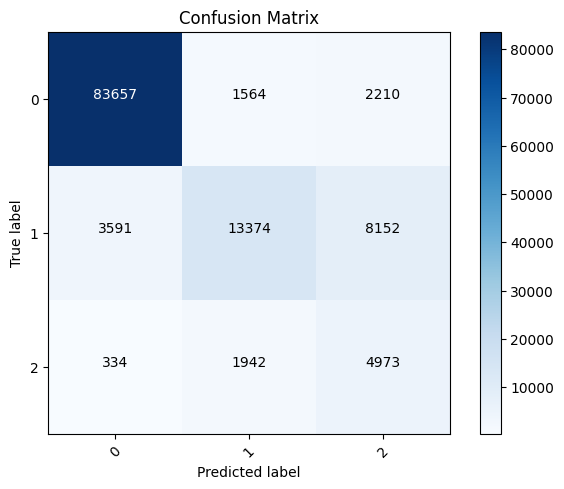

0.8514737430820472
              precision    recall  f1-score   support

     class 0    0.95518   0.95683   0.95601     87431
     class 1    0.79230   0.53247   0.63690     25117
     class 2    0.32429   0.68603   0.44040      7249

    accuracy                        0.85147    119797
   macro avg    0.69059   0.72511   0.67777    119797
weighted avg    0.88286   0.85147   0.85790    119797



In [12]:
for waveletsType in waveletsTypes:
    print("-------------------",waveletsType,"-------------------------")
    checkpoint_filepath = '/home/dll-1/Desktop/eeg/datasets/models/adil/deeplearning/'+waveletsType

    train_path = main_directory +'/'+waveletsType+'/train' + '/'
    valid_path = main_directory +'/'+waveletsType+'/valid' + '/'
    test_path = main_directory +'/'+waveletsType+'/test' + '/'

    train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), classes = class_labels, batch_size = 32, shuffle = True)
    valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = class_labels, batch_size = 16)
    test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), classes = class_labels, batch_size = 16, shuffle = False)

    assert valid_batches.n > 0
    assert test_batches.n > 0
    assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

    imgs, train_labels = next(train_batches)
    plotImages(imgs,train_labels) 

    ##### VGG16

    ###### Import and Build Model

    vgg16_model = keras.applications.vgg16.VGG16()

    vgg16_model_custom = Sequential()
    for layer in vgg16_model.layers[:-1]:
        vgg16_model_custom.add(layer)

    # for layer in model.layers:
    #     layer.trainable = False

    vgg16_model_custom.add(Dense(3, activation = 'softmax'))

    vgg16_model_custom.summary()
    vgg16_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])



    google_lenet = GoogLeNet()

    google_lenet.summary()
    google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])


    
    google_lenet_model = evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath)
    test_model(google_lenet,test_batches,"googlenet")

    vgg16_model_custom = evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath)
    test_model(vgg16_model_custom, test_batches,"vgg16")

    